In [2]:
import matplotlib.pyplot as plt
import numpy as np
import random
import shapely as shp

## Voronoi diagram

\draw[fill=orange](-0.33, 1.33)--(0.18, 1.33)--(0.38, 0.96)--(0.17, 0.82)--(-0.33, 0.93)--(-0.33, 1.33);
\draw[fill=cyan](-0.33, -0.13)--(-0.33, 0.93)--(0.17, 0.82)--(0.23, 0.71)--(-0.13, -0.07)--(-0.19, -0.13)--(-0.33, -0.13);
\draw[fill=orange](-0.19, -0.13)--(-0.13, -0.07)--(0.42, 0.37)--(0.6, 0.31)--(0.69, 0.2)--(0.64, -0.13)--(-0.19, -0.13);
\draw[fill=cyan](0.38, 0.96)--(0.57, 1.02)--(0.77, 0.78)--(0.39, 0.54)--(0.23, 0.71)--(0.17, 0.82)--(0.38, 0.96);
\draw[fill=orange](0.23, 0.71)--(0.39, 0.54)--(0.42, 0.37)--(-0.13, -0.07)--(0.23, 0.71);
\draw[fill=orange](0.6, 1.33)--(0.6, 1.14)--(0.57, 1.02)--(0.38, 0.96)--(0.18, 1.33)--(0.6, 1.33);
\draw[fill=cyan](0.57, 1.02)--(0.6, 1.14)--(1.6, 1.14)--(1.36, 0.88)--(0.96, 0.72)--(0.87, 0.73)--(0.77, 0.78)--(0.57, 1.02);
\draw[fill=orange](0.64, -0.13)--(0.69, 0.2)--(0.83, 0.24)--(1.2, -0.13)--(0.64, -0.13);
\draw[fill=cyan](0.87, 0.73)--(0.6, 0.31)--(0.42, 0.37)--(0.39, 0.54)--(0.77, 0.78)--(0.87, 0.73);
\draw[fill=orange](0.6, 0.31)--(0.

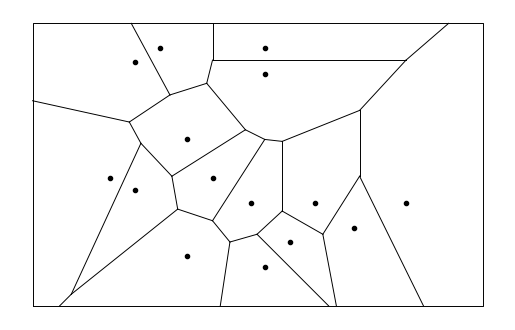

In [43]:
import matplotlib.pyplot as plt
import numpy as np
import random
import shapely as shp

#n_points = 15
#random_points = [(random.randint(0,25),random.randint(0,18)) for i in range(n_points)]

random_points = [
    (13, 18),
    (3, 17),
    (17, 6),
    (13, 1),
    (7, 11),
    (3, 7),
    (12, 6),
    (9, 8),
    (13, 16),
    (20, 4),
    (1, 8),
    (5, 18),
    (24, 6),
    (7, 2),
    (15, 3)
]

scale = 15
random_points = [(rp[0]/scale,rp[1]/scale) for rp in random_points]
random_points = [(round(rp[0],2),round(rp[1],2)) for rp in random_points]

voronoi = shp.voronoi_polygons(
    shp.MultiPoint(random_points),
    only_edges=True,
).geoms
voronoi = list(voronoi)

min_x, max_x = -5, 30
min_y, max_y = -2, 20
min_x, max_x = round(min_x/scale,2), round(max_x/scale,2)
min_y, max_y = round(min_y/scale,2), round(max_y/scale,2)

coords = [(min_x,min_y),(max_x,min_y),(max_x,max_y),(min_x,max_y),(min_x,min_y)]
plane = shp.Polygon(coords)
voronoi = [plane.intersection(v) for v in voronoi]
voronoi = [v for v in voronoi if v]

rounded = [list(p.coords) for p in voronoi]
rounded = [
    [(round(p2[0],2),round(p2[1],2)) for p2 in p] 
    for p in rounded
]

for r in rounded:
    plt.plot(
        [r2[0] for r2 in r],
        [r2[1] for r2 in r],
        'k',
        linewidth=.7
    )
for p in random_points:
    plt.plot(p[0],p[1], '.k')

plt.plot(*plane.exterior.xy,'k',linewidth=.7)
plt.gca().set_aspect('equal', adjustable='box')
plt.gca().set_axis_off()

def poly_to_coords(P):
    return [(round(x[0],2),round(x[1],2)) for x in list(P.exterior.coords)]

voronoi_areas = shp.voronoi_polygons(
    shp.MultiPoint(random_points)
).geoms
voronoi_areas = list(voronoi_areas)
voronoi_areas = [plane.intersection(v) for v in voronoi_areas]
voronoi_areas = [v for v in voronoi_areas if v]

to_str = lambda el: [str(x) for x in poly_to_coords(el)]
for va in voronoi_areas:
    print(f'\\draw[fill={"orange" if random.randint(0,1)==1 else "cyan"}]{"--".join(to_str(va))};')

#for p in rounded:
#    print(f'\\draw {p[0]} -- {p[1]};')

points = "--".join(
    [str(x) for x in 
     [(min_x,min_y),(max_x,min_y),
      (max_x,max_y),(min_x,max_y),
      (min_x,min_y)]]
)
print(f'\\draw {points};')

for p in random_points:
    print(f'\\node at {p} {"{textbullet}"};'.replace('{','{\\'))

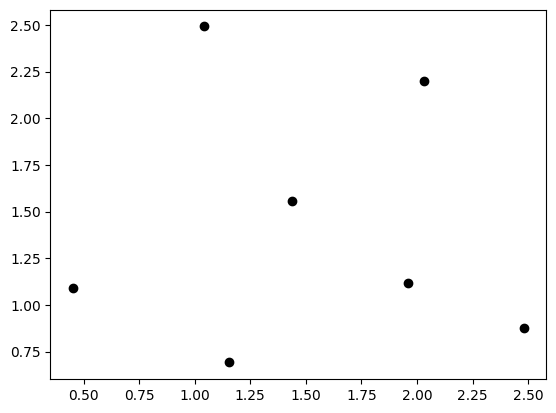

In [60]:
random_points = [
    (random.random()*3,random.random()*3) for i in range(7)
]

for p in random_points:
    plt.plot(p[0],p[1],'ok')

In [61]:
x = np.array(random_points).round(1)
for i in x:
    print(f'\draw ({i[0]},{i[1]}) circle (.2);')

\draw (2.5,0.9) circle (.2);
\draw (1.4,1.6) circle (.2);
\draw (2.0,1.1) circle (.2);
\draw (1.0,2.5) circle (.2);
\draw (2.0,2.2) circle (.2);
\draw (0.5,1.1) circle (.2);
\draw (1.2,0.7) circle (.2);
